In [1]:
import torch
import copy
from torch.utils.data import DataLoader
import json
from datasets import load_dataset
from evaluate import load as load_metric
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.optimization import AdamW
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import random
import time
import os
import sys
import pickle
from common_code import *

In [2]:
# Hyperparameters
epochs = 12 # epochs to train (unless validation loss rises)
bs = 1
learn = 5e-5
early_stop_patience = 1 # >= 1 (if val loss increases, runs early_stop_patience more epochs, then stops)
mod_size = "1.4b"

model_title = f"pythia-{mod_size}-deduped"
model_name = "EleutherAI/" + model_title
model_revision = "step143000"
model_cache_dir = "./"+ model_title +"/"+model_revision

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model = GPTNeoXForCausalLM.from_pretrained(
  model_name,
  revision=model_revision,
  cache_dir=model_cache_dir,
)

tokenizer = AutoTokenizer.from_pretrained(
  model_name,
  revision=model_revision,
  cache_dir=model_cache_dir,
)
# if tokenizer.pad_token is None:
#     tokenizer.add_special_tokens({'pad_token': '[PAD]'})
#     model.resize_token_embeddings(len(tokenizer))
# tokenizer.save_pretrained(f"loss_ratio/pythia-{mod_size}")
  
model.half()
model.eval()
model.to(device)
mem_stats()

Total Memory: 15.77 GB
Reserved Memory: 2.74 GB (17.40%)
Remaining Memory: 13.03 GB (82.60%)
---------------------------------
Allocated Memory: 2.73 GB (17.30%)
Percent of Reserved Allocated: 99.44%



In [3]:
dataset = list(dict.fromkeys(entry["text"] for entry in load_dataset("wk1/the_pile_val.py", split="validation").shuffle(seed=229)))
dataset = dataset[:len(dataset)//40]
train_dataset = dataset[:len(dataset)//2]
val_dataset = dataset[len(dataset)//2:]
print(len(train_dataset))

No config specified, defaulting to: the_pile_val/all
Found cached dataset the_pile_val (/home/ec2-user/.cache/huggingface/datasets/the_pile_val/all/0.0.0/33c9237089c5fb09f83b2ab7ac73d703de97fc4d122e4b82a7777d85b0919e30)
Loading cached shuffled indices for dataset at /home/ec2-user/.cache/huggingface/datasets/the_pile_val/all/0.0.0/33c9237089c5fb09f83b2ab7ac73d703de97fc4d122e4b82a7777d85b0919e30/cache-0289bfade3adba36.arrow


2678


In [5]:
## Collate functions for loading dataset
def collate_fn(batch):
    tokens = [tokenizer.encode(example, return_tensors="pt", truncation=True,max_length=model.config.max_position_embeddings) for example in batch]
    max_length = max([t.size(1) for t in tokens])
    tokens_padded = [torch.cat([t, t.new_zeros(t.size(0), max_length - t.size(1))], dim=1) for t in tokens]
    tokens_padded = torch.cat(tokens_padded, dim=0)
    return {
        "input_ids":tokens_padded,
        "labels":tokens_padded,
        "attention_mask": torch.tensor(tokens_padded>0,dtype=int)
    }
def train(model, train_dataset, val_dataset, collate_fn, batch_size, epochs):
    model.config.use_cache = False
    training_args = TrainingArguments(output_dir="fine-tuning",
                                        do_train=True,
                                        do_eval=True,
                                        num_train_epochs=epochs,
                                        per_device_train_batch_size=batch_size,
                                        per_device_eval_batch_size=batch_size,
                                        evaluation_strategy="epoch",
                                        logging_strategy="epoch",
                                        save_strategy="epoch",
                                        gradient_accumulation_steps=1,
                                        gradient_checkpointing=True,
                                        load_best_model_at_end = True,
                                        optim="adafactor",
                                        )
    trainer = Trainer(model=model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    tokenizer=tokenizer,
                    data_collator=collate_fn,
                    callbacks=[EarlyStoppingCallback(early_stop_patience, 0.0)] # if val loss improve for >1 iterations, end. 
                    )
    trainer.train()
    return model

In [6]:
train(model, train_dataset, val_dataset, collate_fn, bs, epochs)
model.save_pretrained(f"loss_ratio/pythia-{mod_size}", from_pt=True) 
del model
torch.cuda.empty_cache()

/tmp/ipykernel_29430/1653692871.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.039100,3.171875
2,1.903800,3.320312


/tmp/ipykernel_29430/1653692871.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


In [6]:
model = GPTNeoXForCausalLM.from_pretrained(f"./loss_ratio/pythia-{mod_size}")
train_dl = DataLoader(train_dataset, batch_size = 1, collate_fn=collate_fn)
val_dl = DataLoader(val_dataset, batch_size = 1, collate_fn=collate_fn)
train_result_ft = compute_dataloader_cross_entropy_v2(model,train_dl,device)
val_result_ft = compute_dataloader_cross_entropy_v2(model,val_dl,device)
del model
torch.cuda.empty_cache()
model = GPTNeoXForCausalLM.from_pretrained(
  model_name,
  revision=model_revision,
  cache_dir=model_cache_dir,
)
train_result_base = compute_dataloader_cross_entropy_v2(model,train_dl,device)
val_result_base = compute_dataloader_cross_entropy_v2(model,val_dl,device)

train_ratios = (train_result_ft/train_result_base)[~torch.any((train_result_ft/train_result_base).isnan(),dim=1)]
val_ratios = (val_result_ft/val_result_base)[~torch.any((val_result_ft/val_result_base).isnan(),dim=1)]

train_result_ft = train_result_ft[~torch.any(train_result_ft.isnan(),dim=1)]
val_result_ft = val_result_ft[~torch.any(val_result_ft.isnan(),dim=1)]

with open(f"loss_ratio/pythia-{mod_size}/loss.pickle","wb") as f:
    pickle.dump((train_result_ft,val_result_ft),f)

with open(f"loss_ratio/pythia-{mod_size}/ratios.pickle","wb") as f:
    pickle.dump((train_ratios,val_ratios),f)

/tmp/ipykernel_22047/1653692871.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


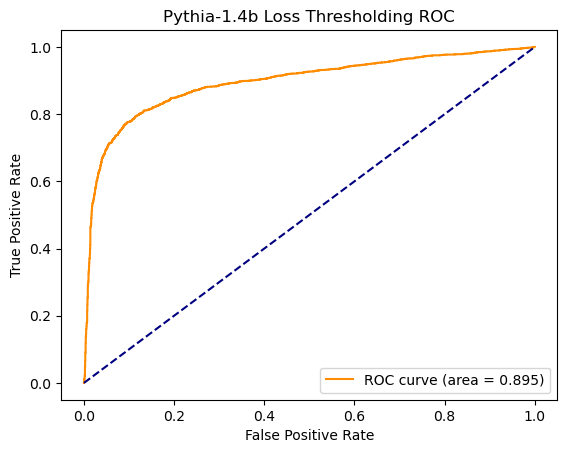

In [7]:
# Generate ROC curve 
with open(f"loss_ratio/pythia-{mod_size}/loss.pickle","rb") as f:
    train_result_ft,val_result_ft = pickle.load(f)

fpr, tpr, thresholds = roc_curve(torch.cat((torch.zeros_like(train_result_ft),torch.ones_like(val_result_ft))).flatten(),
                                 torch.cat((train_result_ft,val_result_ft)).flatten())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title(f"Pythia-{mod_size} Loss Thresholding ROC")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

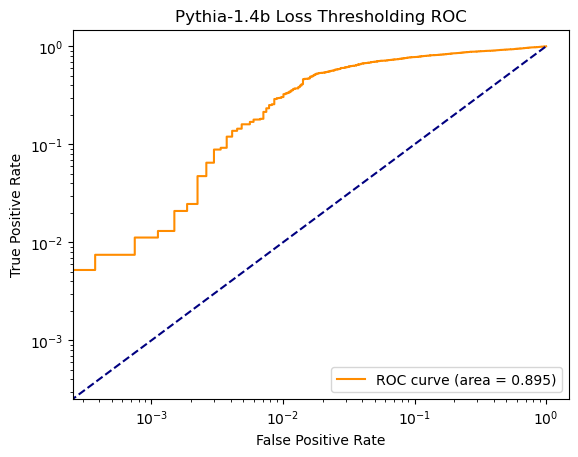

In [8]:
# Generate ROC curve 
with open(f"loss_ratio/pythia-{mod_size}/loss.pickle","rb") as f:
    train_result_ft,val_result_ft = pickle.load(f)

fpr, tpr, thresholds = roc_curve(torch.cat((torch.zeros_like(train_result_ft),torch.ones_like(val_result_ft))).flatten(),
                                 torch.cat((train_result_ft,val_result_ft)).flatten())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.loglog(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title(f"Pythia-{mod_size} Loss Thresholding ROC")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

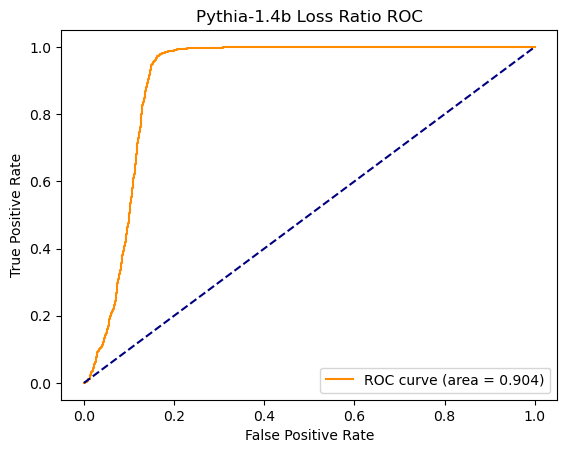

In [9]:
# Generate ROC curve 
with open(f"loss_ratio/pythia-{mod_size}/ratios.pickle","rb") as f:
    train_ratios,val_ratios = pickle.load(f)

fpr, tpr, thresholds = roc_curve(torch.cat((torch.zeros_like(train_ratios),torch.ones_like(val_ratios))).flatten(),
                                 torch.cat((train_ratios,val_ratios)).flatten())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title(f"Pythia-{mod_size} Loss Ratio ROC")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

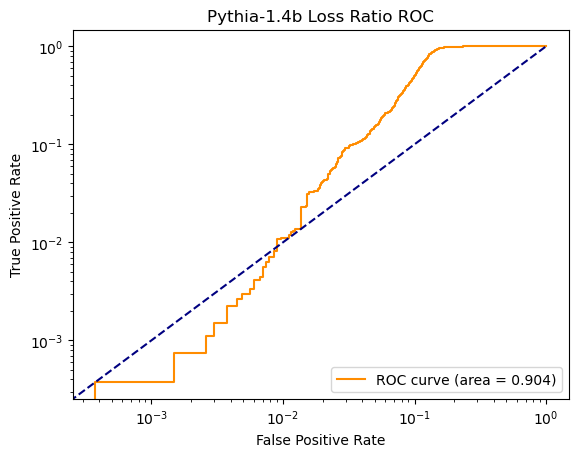

: 

In [10]:
# Generate ROC curve 
with open(f"loss_ratio/pythia-{mod_size}/ratios.pickle","rb") as f:
    train_ratios,val_ratios = pickle.load(f)

fpr, tpr, thresholds = roc_curve(torch.cat((torch.zeros_like(train_ratios),torch.ones_like(val_ratios))).flatten(),
                                 torch.cat((train_ratios,val_ratios)).flatten())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.loglog(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title(f"Pythia-{mod_size} Loss Ratio ROC")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()